# <a> Project Objective  </a>
#### The main objective of this project is to **forecast the weekly sales for each Walmart store over the next 4 weeks**.  

# <a> Walmart Sales Dataset (45 Stores) </a>

- The Walmart sales dataset is a popular time-series dataset used in forecasting and retail analytics. It contains weekly sales records from 45 different Walmart stores across the United States. Each row represents sales for one store in a given week, along with additional economic and seasonal indicators.

# Column Description

| **Column Name**   | **Description** |
|--------------------|-----------------|
| **Store**         | The unique store ID (1 to 45). Each number represents one Walmart store. |
| **Date**          | The week of sales (weekly time series). Data is usually in "YYYY-MM-DD" format. |
| **Weekly_Sales**  | Total sales revenue for that store during the given week (target variable for forecasting). |
| **Holiday_Flag**  | Binary variable (1 = holiday week, 0 = non-holiday week). Major U.S. holidays include Super Bowl, Labor Day, Thanksgiving, and Christmas. |
| **Temperature**   | Average temperature (in Fahrenheit) in the region of the store for that week. |
| **Fuel_Price**    | Average fuel price (per gallon) in the region of the store. |
| **CPI**           | Consumer Price Index (measures inflation, cost of goods). |
| **Unemployment**  | Unemployment rate (%) in the region of the store. |


# <a> 1. Importing Libraries </a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import plotly.graph_objects as go
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib inline
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

# <a> 2. Load Dataset </a>

In [2]:
# Load dataset
df = pd.read_csv("walmart_sales.csv")
df.head(10)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
5,1,12-03-2010,1439541.59,0,57.79,2.667,211.380643,8.106
6,1,19-03-2010,1472515.79,0,54.58,2.720,211.215635,8.106
7,1,26-03-2010,1404429.92,0,51.45,2.732,211.018042,8.106
8,1,02-04-2010,1594968.28,0,62.27,2.719,210.820450,7.808
9,1,09-04-2010,1545418.53,0,65.86,2.770,210.622857,7.808


In [3]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

In [4]:
df = df[["Store", "Date", "Weekly_Sales"]]

In [5]:
df.head(10)

,Store,Date,Weekly_Sales
0,1,2010-02-05,1643690.90
1,1,2010-02-12,1641957.44
2,1,2010-02-19,1611968.17
3,1,2010-02-26,1409727.59
4,1,2010-03-05,1554806.68
5,1,2010-03-12,1439541.59
6,1,2010-03-19,1472515.79
7,1,2010-03-26,1404429.92
8,1,2010-04-02,1594968.28
9,1,2010-04-09,1545418.53


In [6]:
df1 = df.sort_values(["Store", "Date"])

In [7]:
store_list = sorted(df["Store"].unique())

In [8]:
initial_store = store_list[0]
store_data = df[df["Store"] == initial_store]

In [9]:
fig = go.Figure()

# Initial trace
fig.add_trace(go.Scatter(
    x = store_data["Date"],
    y = store_data["Weekly_Sales"],
    mode = "lines+markers",
    name = f"Store {initial_store}",
    line = dict(color = 'blue')
))

# Dropdown buttons
dropdown_buttons = []
for store in store_list:
    store_data = df[df["Store"] == store]
    dropdown_buttons.append(
        dict(
            method = 'update',
            label = f"Store {store}",
            args = [
                {'x': [store_data["Date"]], 'y': [store_data["Weekly_Sales"]]},
                {'title': f"Weekly sale of Store-{store}"}
            ]
        )
    )

# X-axis styling
fig.update_xaxes(
    rangeslider_visible = True,
    showgrid = True,
    gridcolor = "lightgray"
)

# Y-axis styling
fig.update_yaxes(
    showgrid = True,
    gridcolor = "lightgray"
)

# Layout styling
fig.update_layout(
    title = f"Weekly sale of Store-{initial_store}",
    title_font_size = 24,
    xaxis_title = "Date",
    yaxis_title = "Weekly Sales",
    height = 700,
    plot_bgcolor = "lightgray",
    paper_bgcolor = "white",
    updatemenus=[dict(
        buttons=dropdown_buttons,
        direction="down",
        showactive=True,
        x=1.15,
        y=1.15
    )],
    margin = dict(l = 60, b = 60, r = 60, t = 40)
)

fig.show()

# <a> Check Stationarity </a>
- We check for **stationarity** because most time series forecasting models (like AR, MA, ARIMA, SARIMA) assume that the data is stationary.  
- If the data is non-stationary, the model may give misleading results.  
- By making the series stationary (using differencing, transformations, etc.), we ensure that the model can capture meaningful patterns and relationships. 

In [10]:
def check_stationarity(df):
    results = []
    
    for store in sorted(df['Store'].unique()):
        store_data = df[df['Store'] == store].sort_values('Date')
        ts = store_data['Weekly_Sales']
        
        # Run ADF test
        adf_result = adfuller(ts.dropna())
        p_value = adf_result[1]
        
        if p_value < 0.05:
            status = "Stationary"
        else:
            status = "Non-Stationary"
        
        results.append({
            'Store': store,
            'ADF Statistic': adf_result[0],
            'p-value': p_value,
            'Stationarity': status
        })
    
    return pd.DataFrame(results)

In [11]:
stationarity_results = check_stationarity(df)
stationarity_results

,Store,ADF Statistic,p-value,Stationarity
0,1,-5.102186,1.387779e-05,Stationary
1,2,-3.708863,3.990207e-03,Stationary
2,3,-2.963868,3.840926e-02,Stationary
3,4,-2.879382,4.779866e-02,Stationary
4,5,-4.310974,4.251706e-04,Stationary
5,6,-5.492502,2.159486e-06,Stationary
6,7,-4.476254,2.170072e-04,Stationary
7,8,-5.647653,1.002746e-06,Stationary
8,9,-5.008564,2.134309e-05,Stationary
9,10,-5.200703,8.763068e-06,Stationary


In [12]:
def get_p_value(series):
    series = series.dropna()
    result = adfuller(series)
    return result[1]  

In [13]:
def get_differencing_order(series, max_diff=5):
    d = 0
    p_value = get_p_value(series)

    while p_value > 0.05 and d < max_diff:
        d += 1
        series = series.diff().dropna()
        p_value = get_p_value(series)

    return d

In [14]:
def make_stationary(df):
    df = df.copy()
    stationary_dfs = []
    diff_orders = {}

    for store in sorted(df['Store'].unique()):
        store_df = df[df['Store'] == store].sort_values('Date')
        sales_series = store_df['Weekly_Sales']

        # Find differencing order
        d = get_differencing_order(sales_series)
        diff_orders[store] = d

        # Apply differencing
        if d > 0:
            store_df['Weekly_Sales'] = store_df['Weekly_Sales'].diff(d)

        # Keep only rows without NaN after differencing
        store_df = store_df.dropna(subset=['Weekly_Sales'])

        stationary_dfs.append(store_df)

    # Combine all stores back into one DataFrame
    stationary_df = pd.concat(stationary_dfs).sort_values(['Store', 'Date'])

    return stationary_df, diff_orders

In [15]:
stationary_df, diff_orders = make_stationary(df)

print("Best differencing orders per store:")
diff_orders

Best differencing orders per store:


{np.int64(1): 0,
 np.int64(2): 0,
 np.int64(3): 0,
 np.int64(4): 0,
 np.int64(5): 0,
 np.int64(6): 0,
 np.int64(7): 0,
 np.int64(8): 0,
 np.int64(9): 0,
 np.int64(10): 0,
 np.int64(11): 0,
 np.int64(12): 0,
 np.int64(13): 0,
 np.int64(14): 1,
 np.int64(15): 0,
 np.int64(16): 0,
 np.int64(17): 0,
 np.int64(18): 0,
 np.int64(19): 0,
 np.int64(20): 0,
 np.int64(21): 0,
 np.int64(22): 0,
 np.int64(23): 0,
 np.int64(24): 0,
 np.int64(25): 0,
 np.int64(26): 0,
 np.int64(27): 0,
 np.int64(28): 0,
 np.int64(29): 0,
 np.int64(30): 1,
 np.int64(31): 0,
 np.int64(32): 0,
 np.int64(33): 0,
 np.int64(34): 0,
 np.int64(35): 0,
 np.int64(36): 1,
 np.int64(37): 0,
 np.int64(38): 1,
 np.int64(39): 0,
 np.int64(40): 0,
 np.int64(41): 0,
 np.int64(42): 1,
 np.int64(43): 1,
 np.int64(44): 1,
 np.int64(45): 0}

In [16]:
print("\nStationary DataFrame head:")
stationary_df.head()


Stationary DataFrame head:


,Store,Date,Weekly_Sales
0,1,2010-02-05,1643690.90
1,1,2010-02-12,1641957.44
2,1,2010-02-19,1611968.17
3,1,2010-02-26,1409727.59
4,1,2010-03-05,1554806.68


# <a> ACF and PACF Plot </a>

## 1. Autocorrelation Function (ACF)

- The **Autocorrelation Function (ACF)** measures the correlation between a time series and its lagged values.  
- Formula:  

$$
\rho_k = \frac{\text{Cov}(Y_t, Y_{t-k})}{\sqrt{\text{Var}(Y_t) \cdot \text{Var}(Y_{t-k})}}
$$

where
- ρ_k  = autocorrelation at lag  k 
- Y_t = value of the series at time t 
- Y_{t-k} = value at lag k 

- **Interpretation:**  
  - ACF plot shows how past sales (lags) are related to current sales.  
  - Used mainly to identify the **MA (Moving Average)** order `q` in ARIMA/SARIMA.


## 2. Partial Autocorrelation Function (PACF)

- The **Partial Autocorrelation Function (PACF)** measures the direct correlation between a time series and its lag, after removing the effects of all shorter lags.  
- Formula:  

$$
\phi_{kk} = \text{Corr}(Y_t, Y_{t-k} \mid Y_{t-1}, Y_{t-2}, \dots, Y_{t-(k-1)})
$$

where  
- Φ(kk) = partial autocorrelation at lag k  

- **Interpretation:**  
  - PACF plot shows the "pure" relationship between sales and its lagged values.  
  - Used mainly to identify the **AR (AutoRegressive)** order `p` in ARIMA/SARIMA.



#### 3. Why We Use ACF & PACF?

- To determine appropriate hyperparameters for ARIMA/SARIMA models:  
  - **From ACF plot → decide `q` (MA order).**  
  - **From PACF plot → decide `p` (AR order).**  
- Helps avoid random guessing of model parameters.  
- Ensures the model captures the true dependency structure of the sales data.  



#### 4. Rule of Thumb (for model selection)

- **AR (p):** Look for significant spikes in PACF that cut off after lag `p`.  
- **MA (q):** Look for significant spikes in ACF that cut off after lag `q`.  
- **ARMA (p,q):** If both ACF and PACF show gradual decay.



In [17]:
def plot_acf_pacf_for_each_store(stationary_df, nlags=20):
    store_list = sorted(stationary_df['Store'].unique())

    for store in store_list:
        temp = stationary_df[stationary_df["Store"] == store]["Weekly_Sales"].dropna()

        # Skip if store has too few data points
        if len(temp) < nlags:
            print(f"Skipping Store {store} — not enough data")
            continue

        # Compute ACF and PACF
        acf_vals = acf(temp, nlags=nlags)
        pacf_vals = pacf(temp, nlags=nlags)
        lags = list(range(len(acf_vals)))

        # Plot
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.stem(lags, acf_vals)
        plt.xlabel("Lag")
        plt.ylabel("ACF")
        plt.title(f"Store {store} - ACF")

        plt.subplot(1, 2, 2)
        plt.stem(lags, pacf_vals)
        plt.xlabel("Lag")
        plt.ylabel("PACF")
        plt.title(f"Store {store} - PACF")

        plt.tight_layout()
        plt.show()


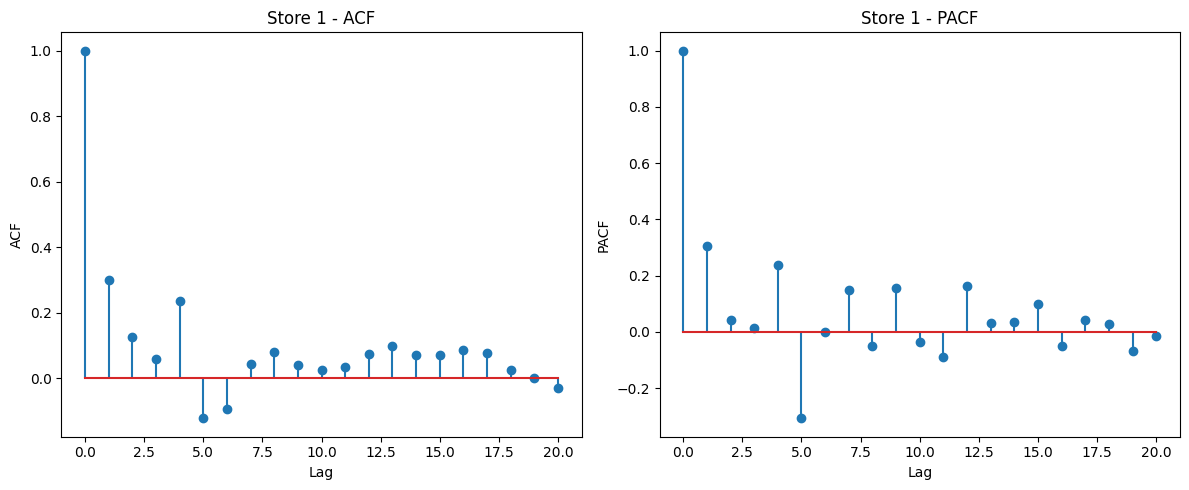

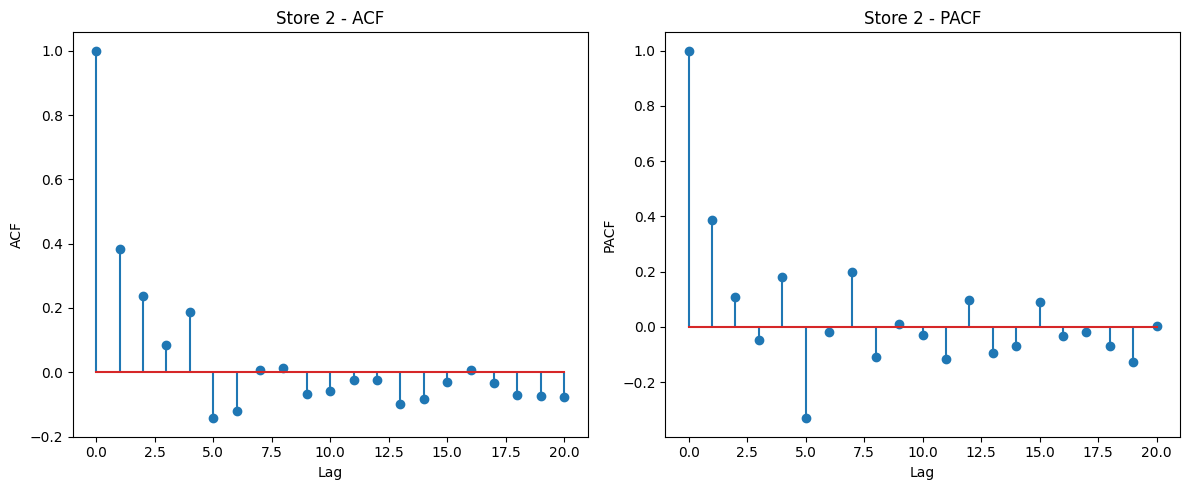

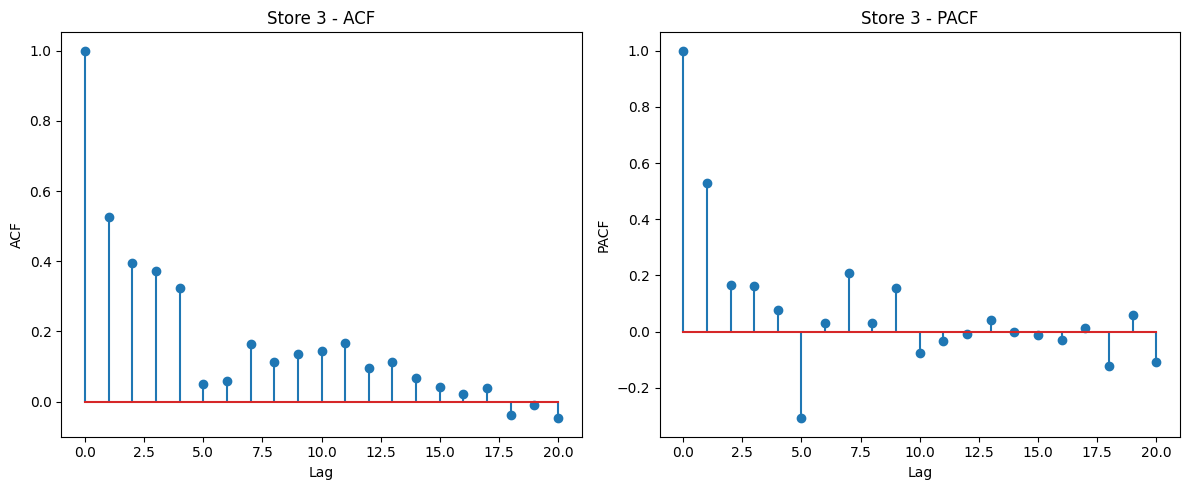

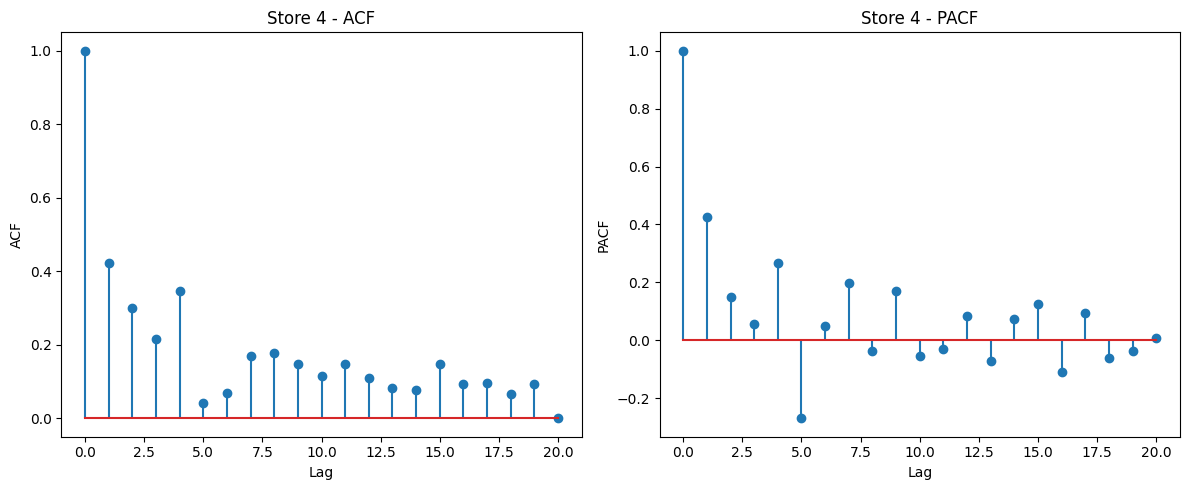

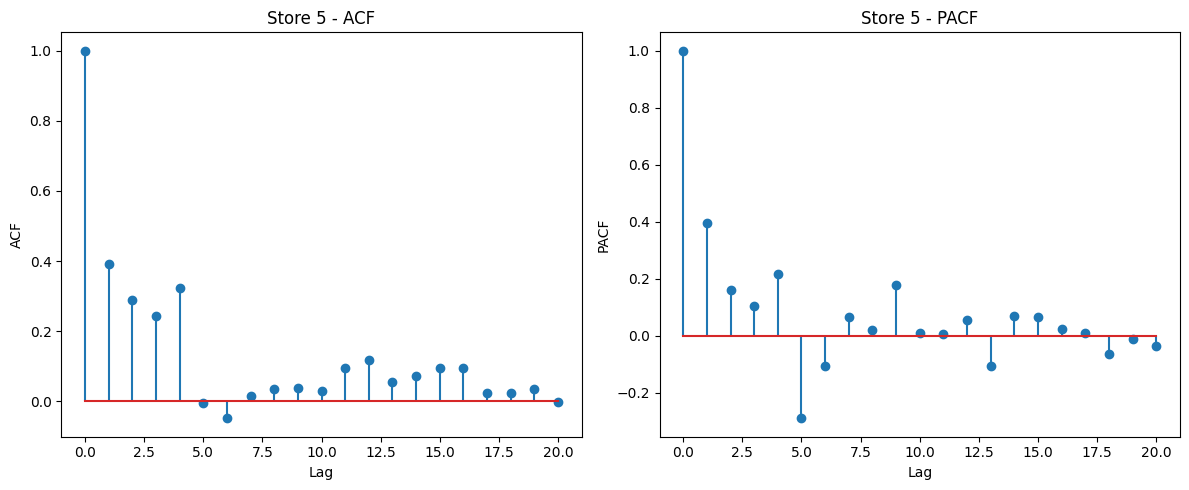

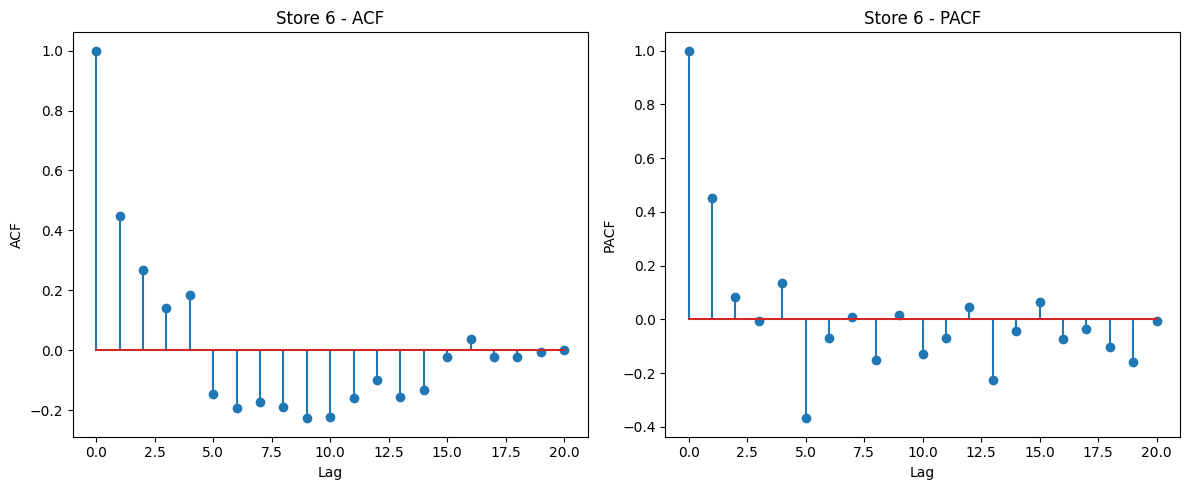

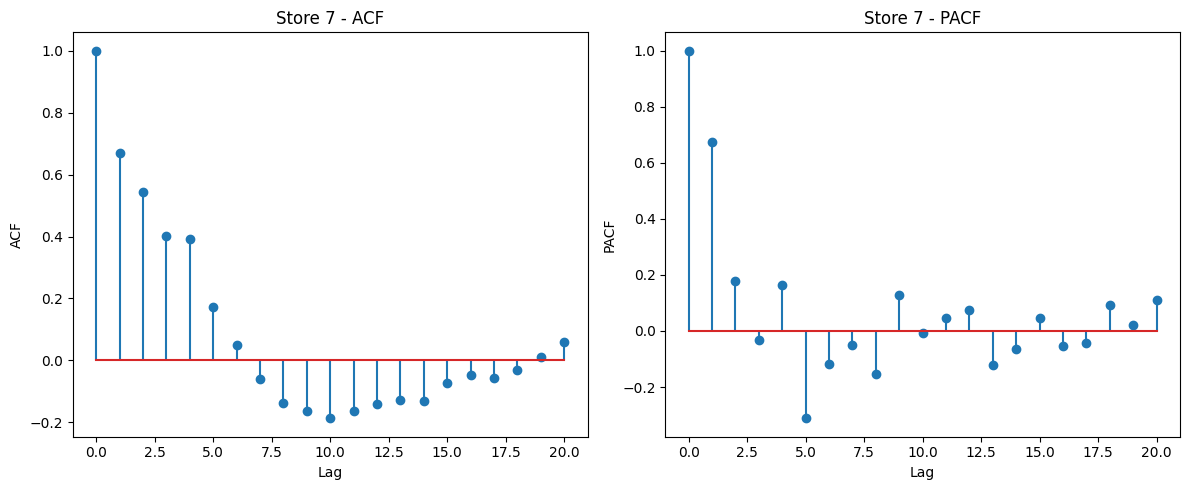

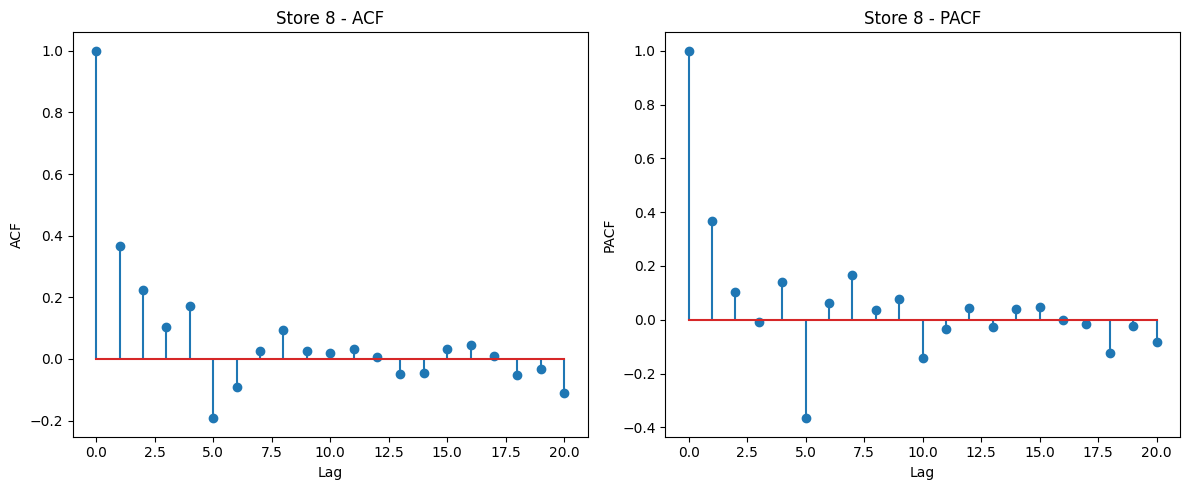

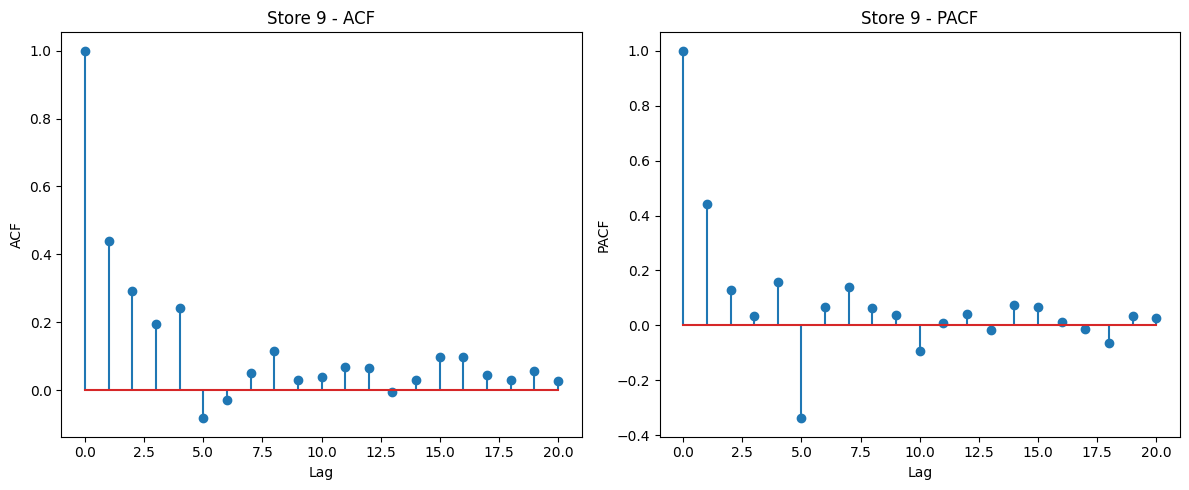

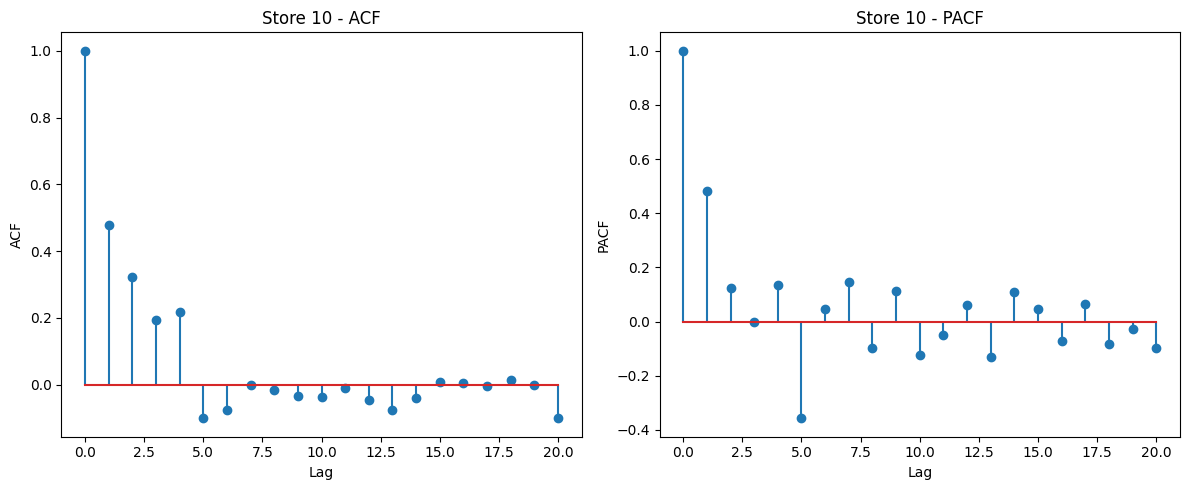

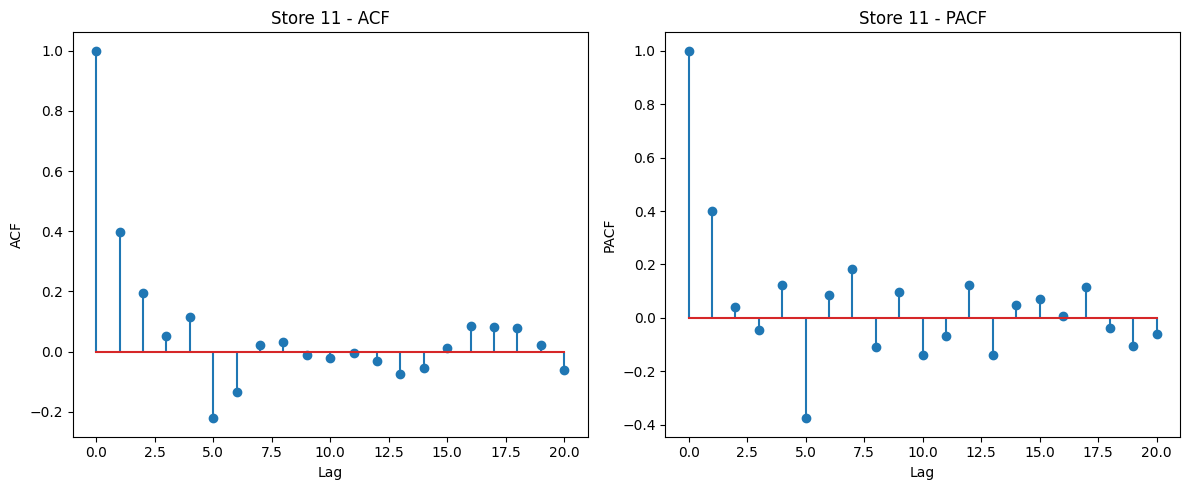

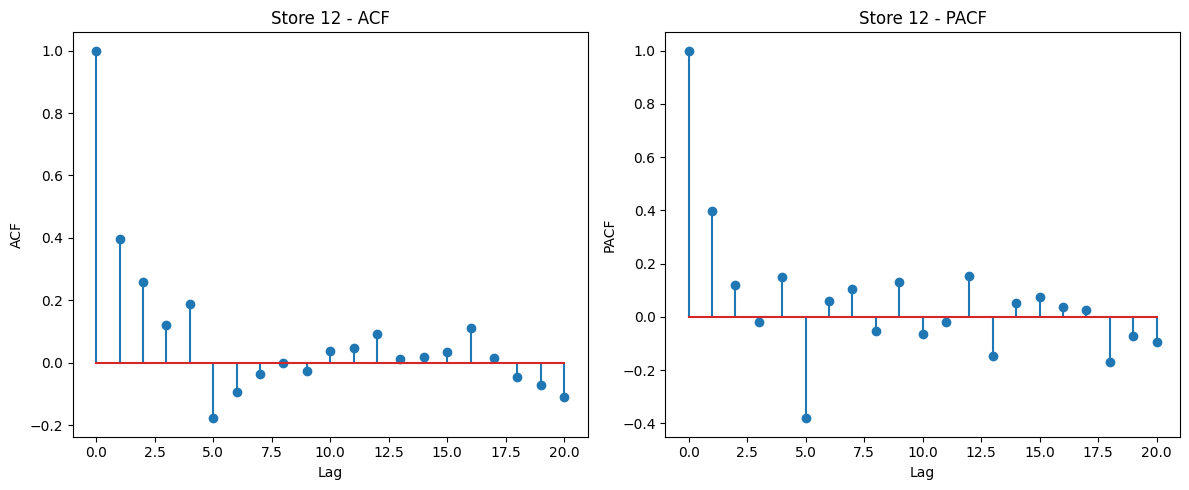

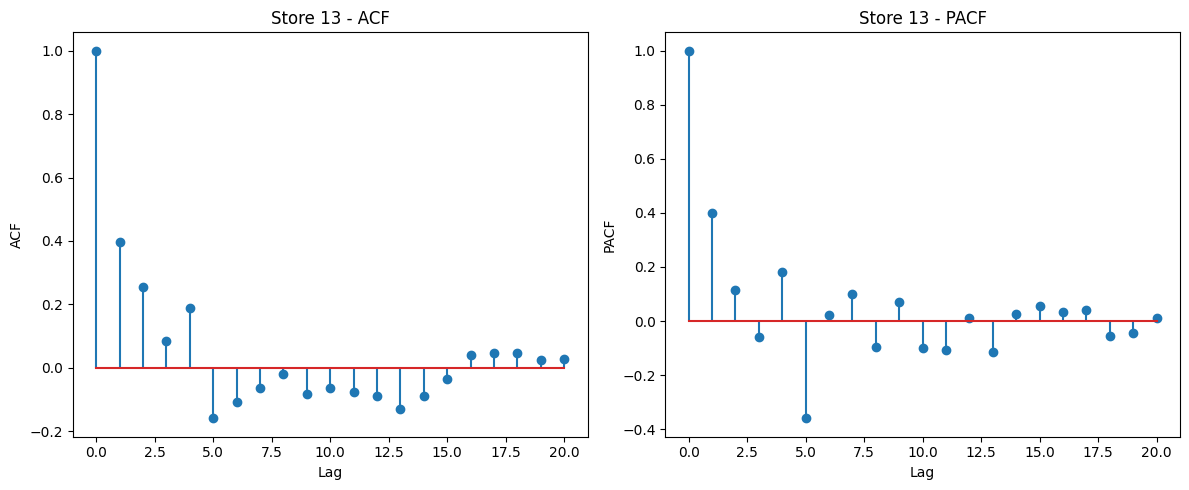

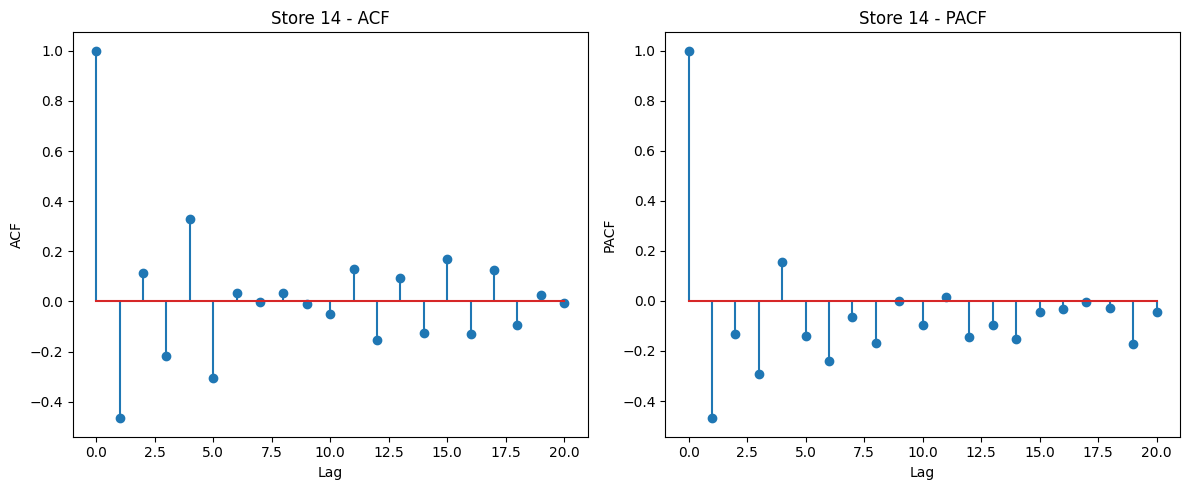

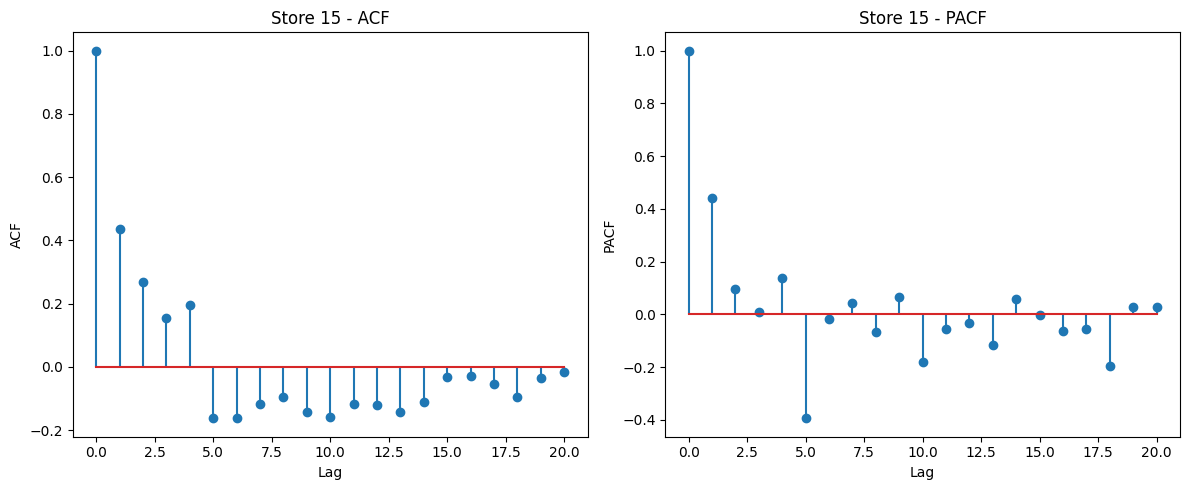

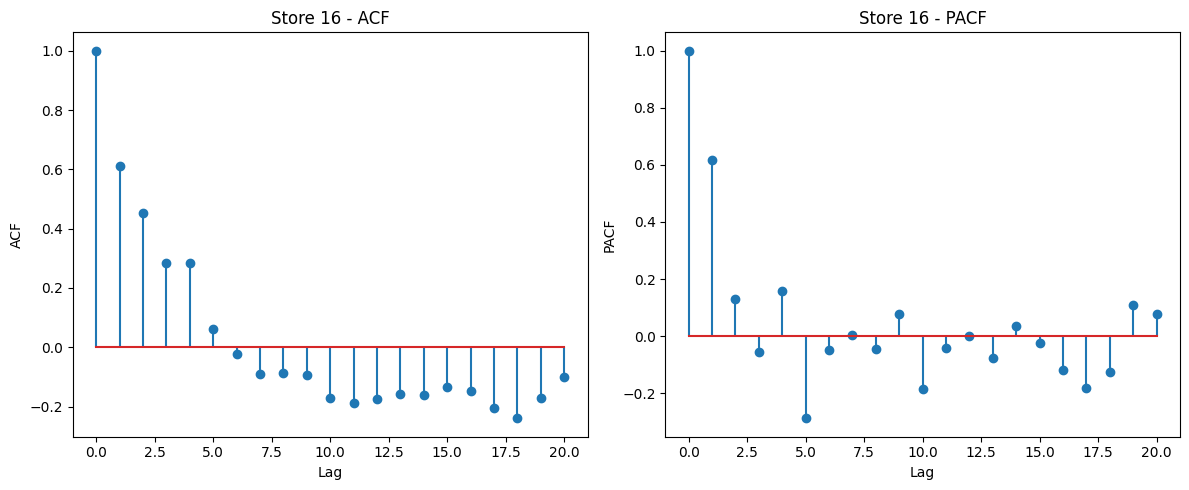

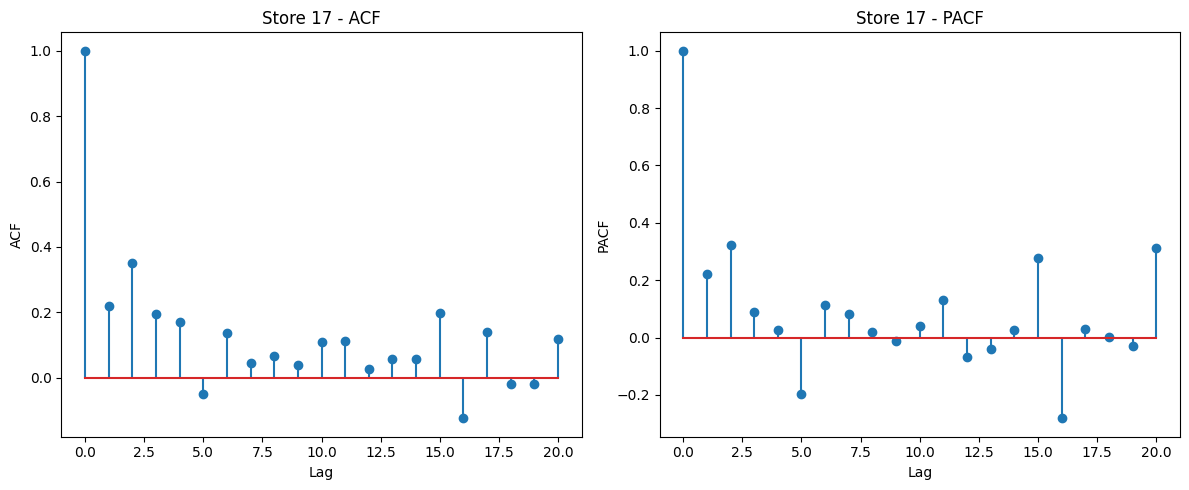

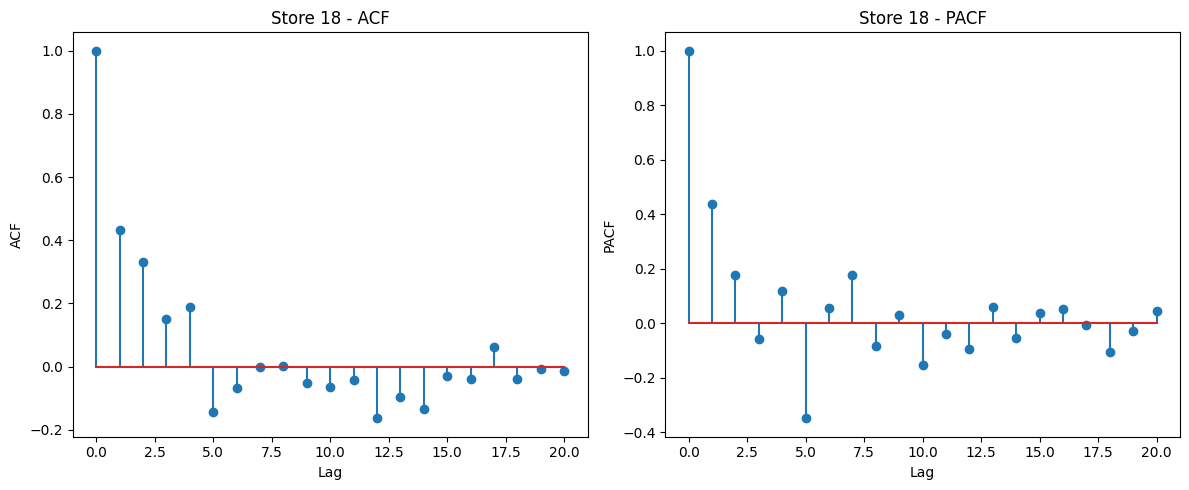

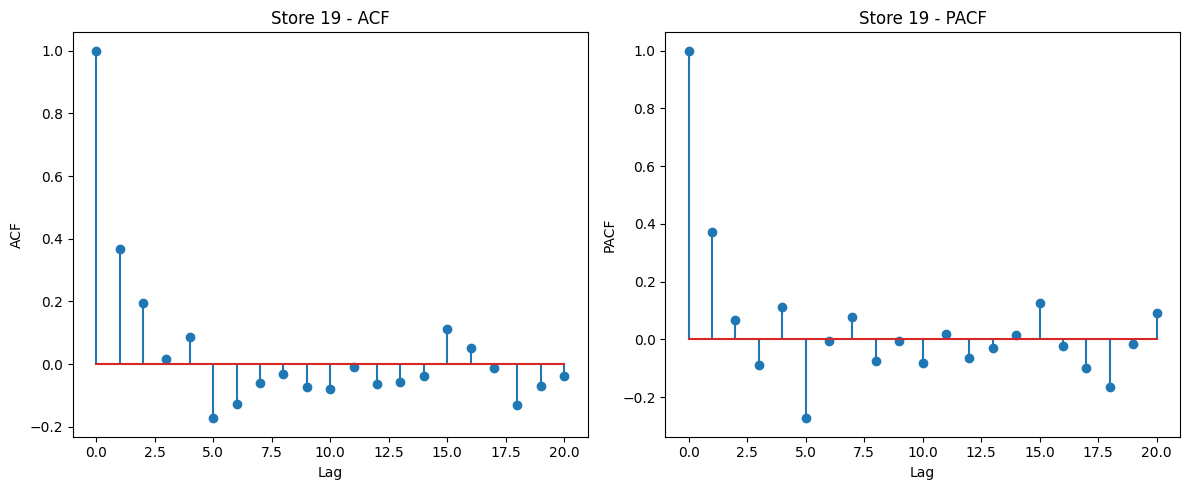

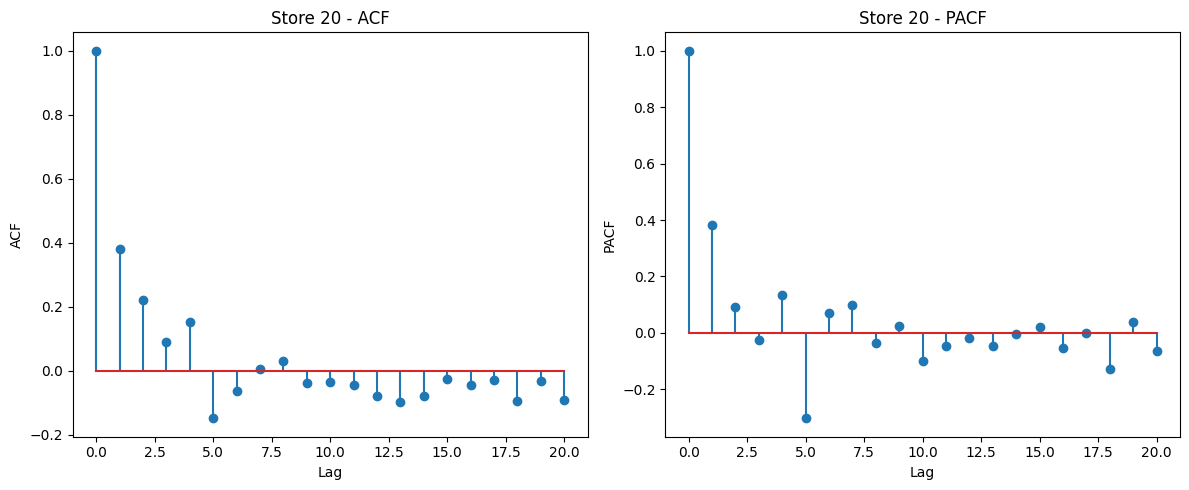

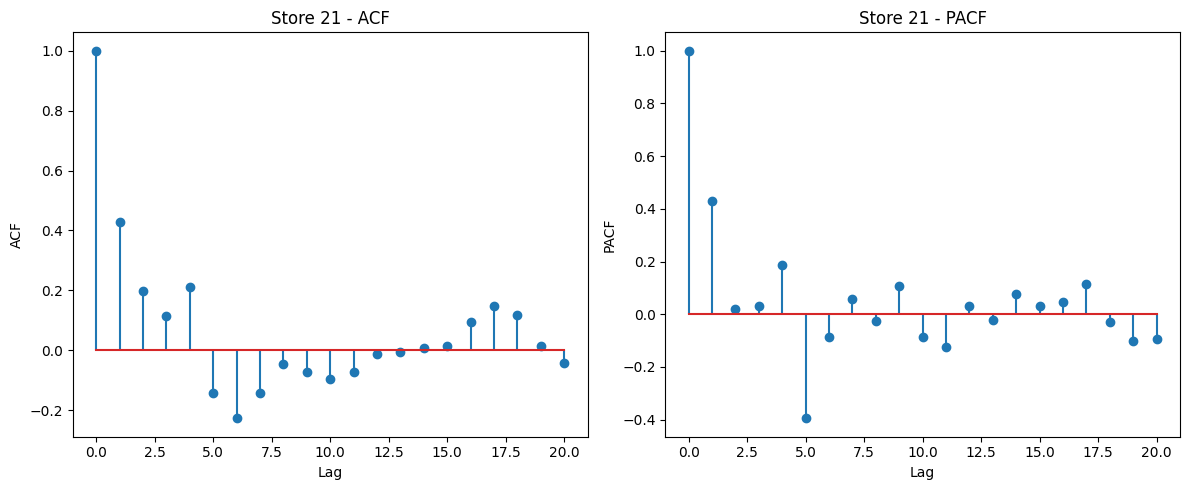

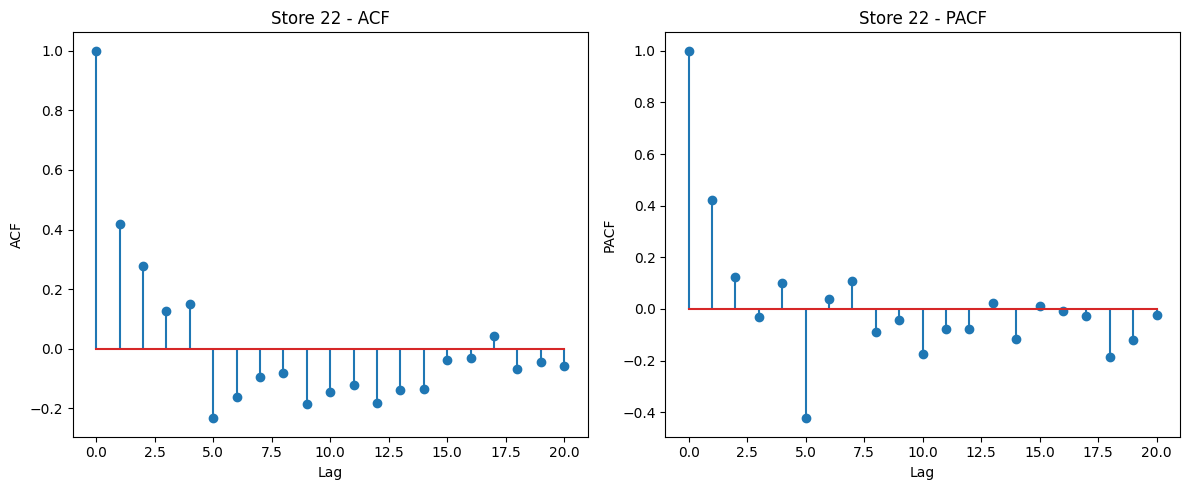

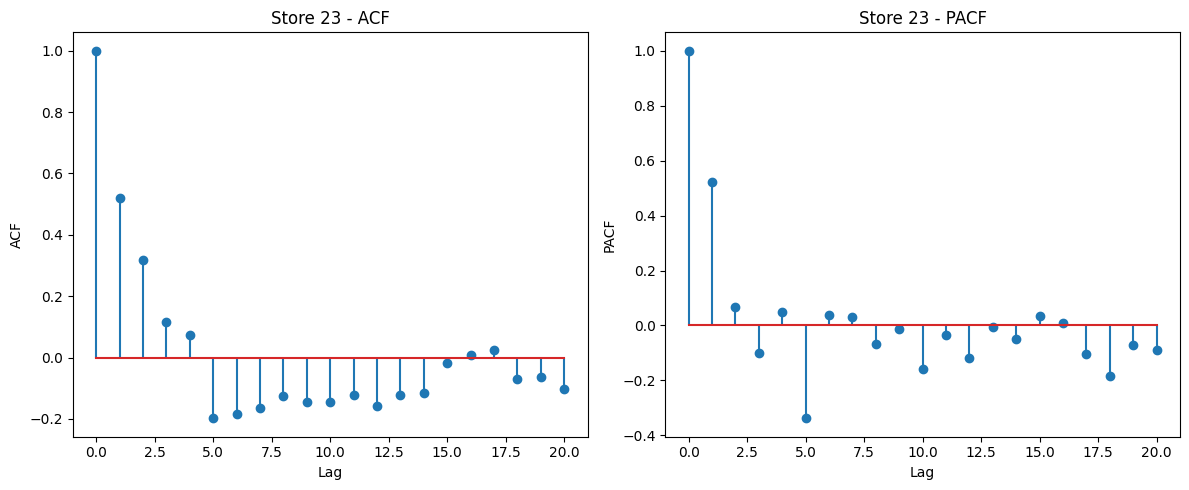

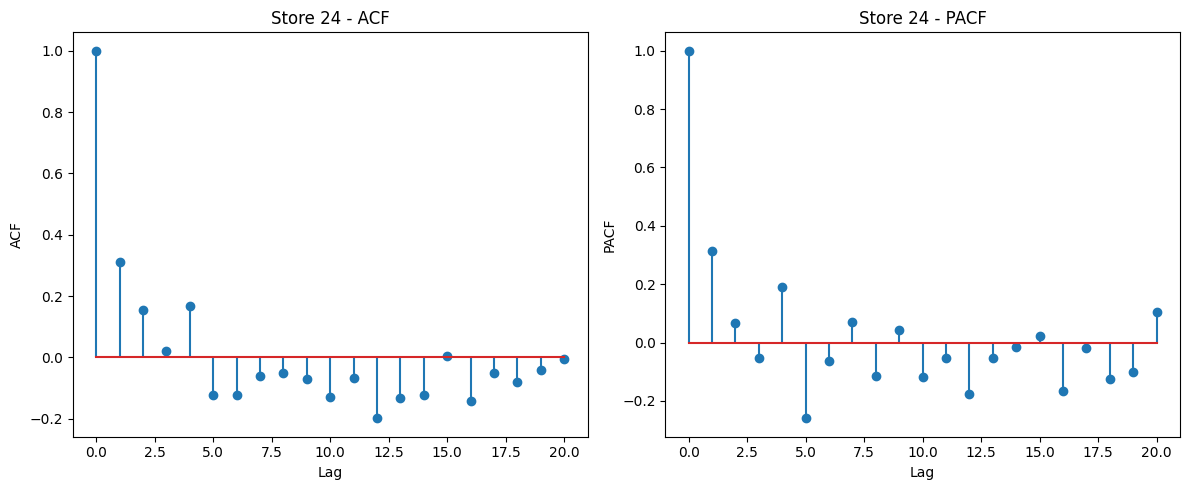

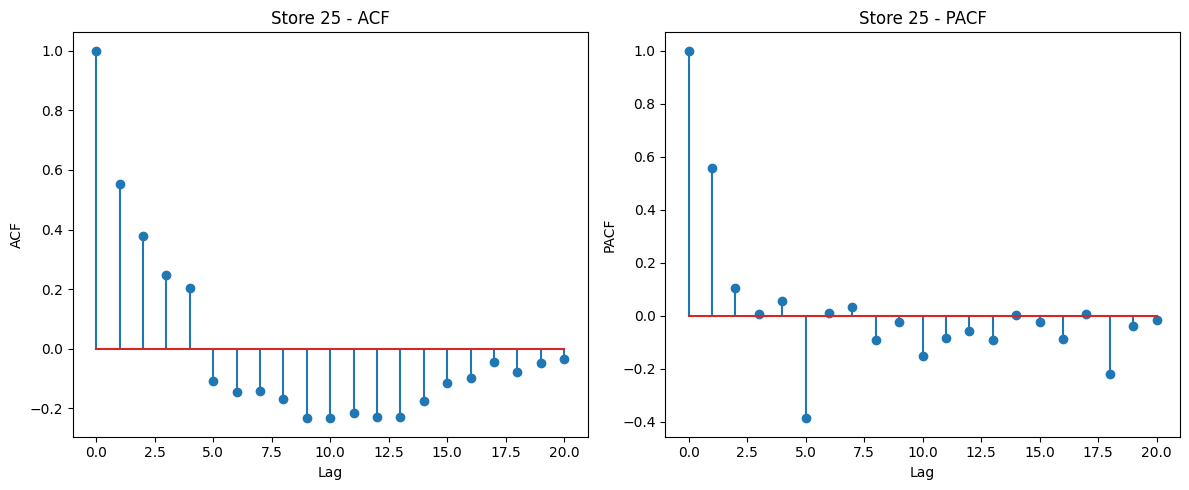

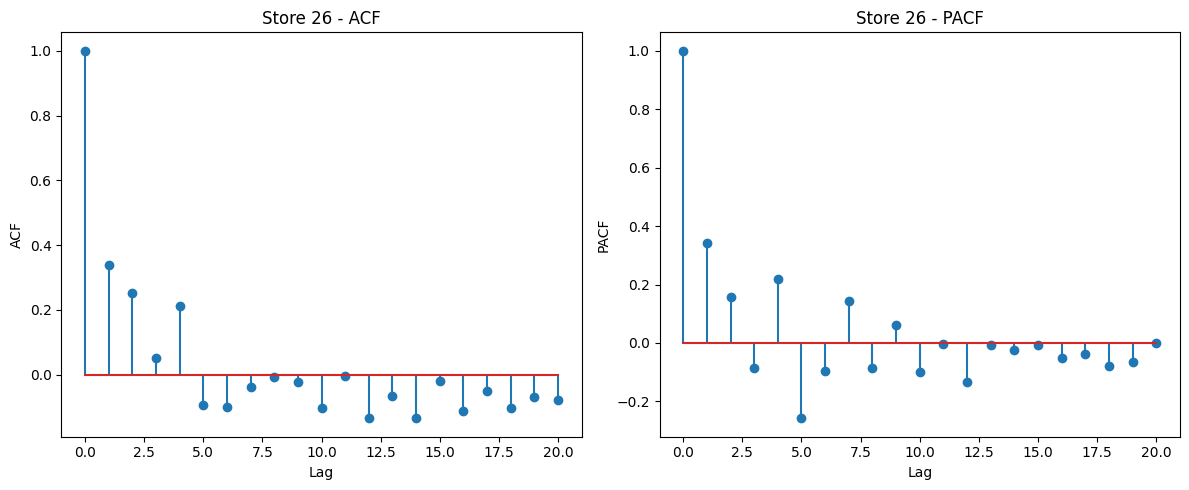

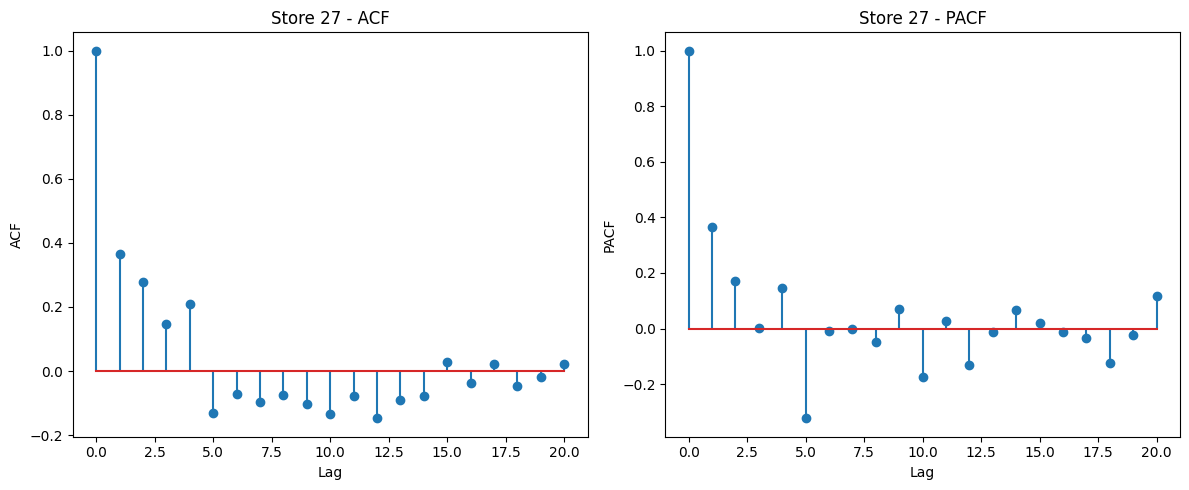

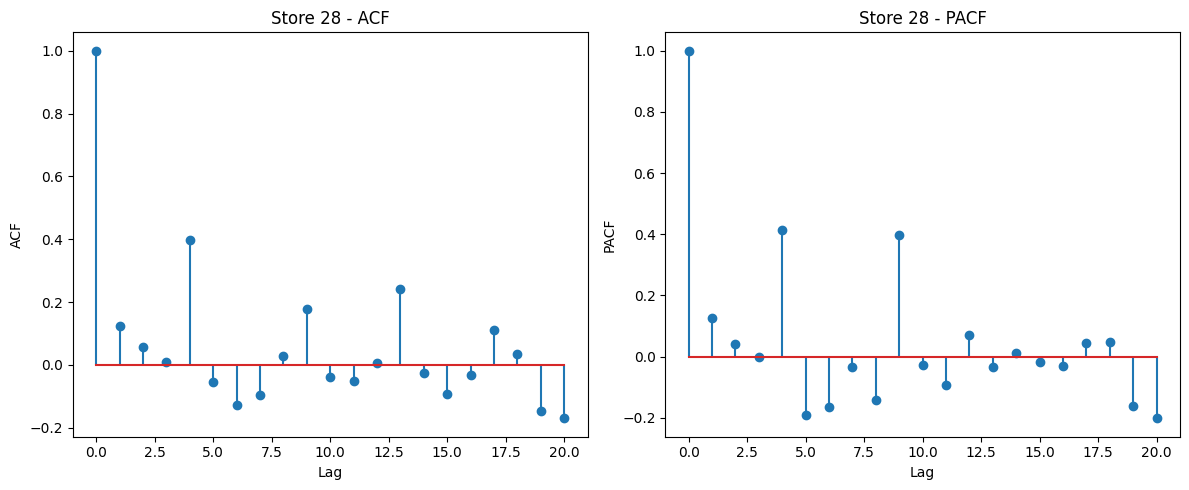

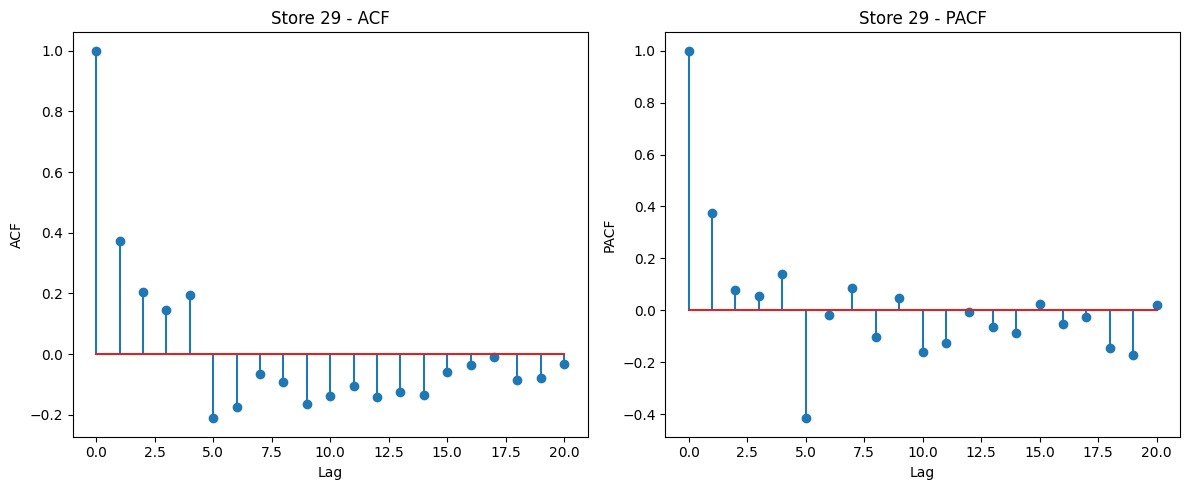

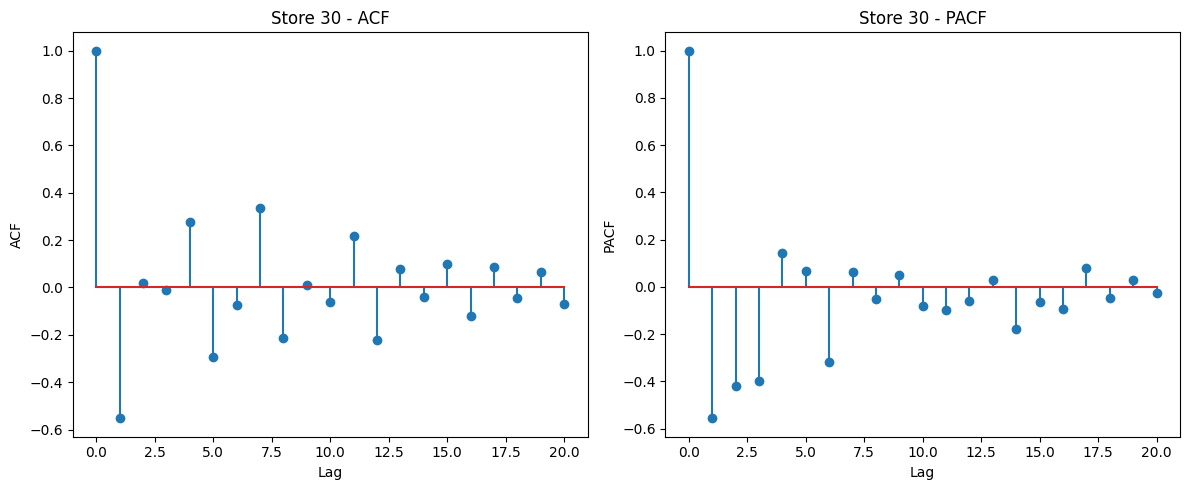

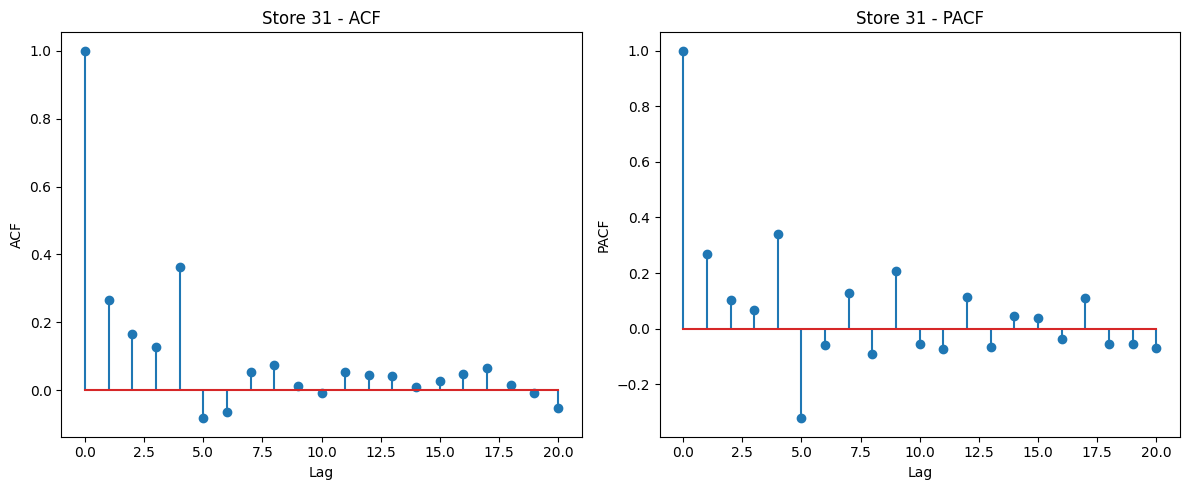

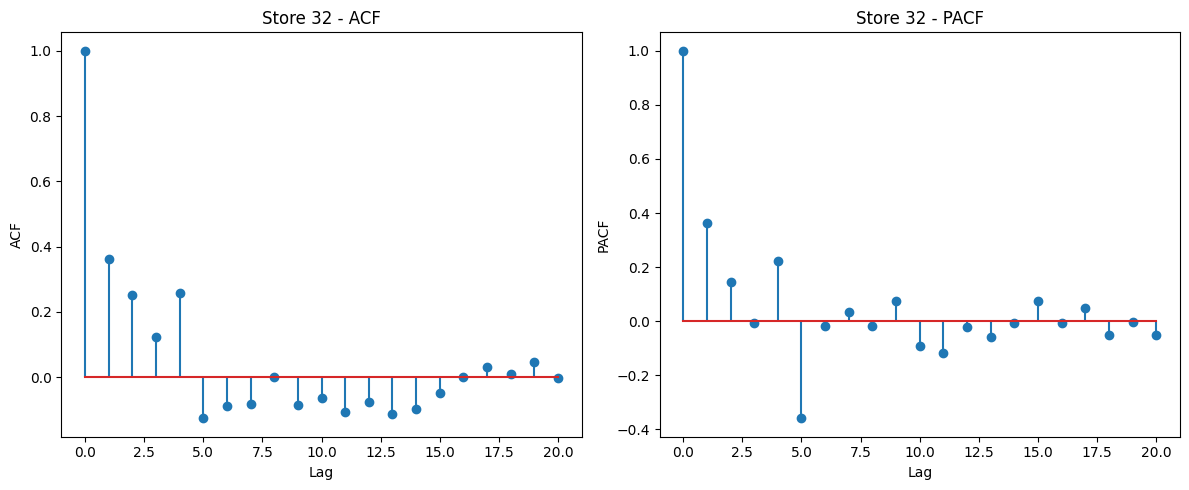

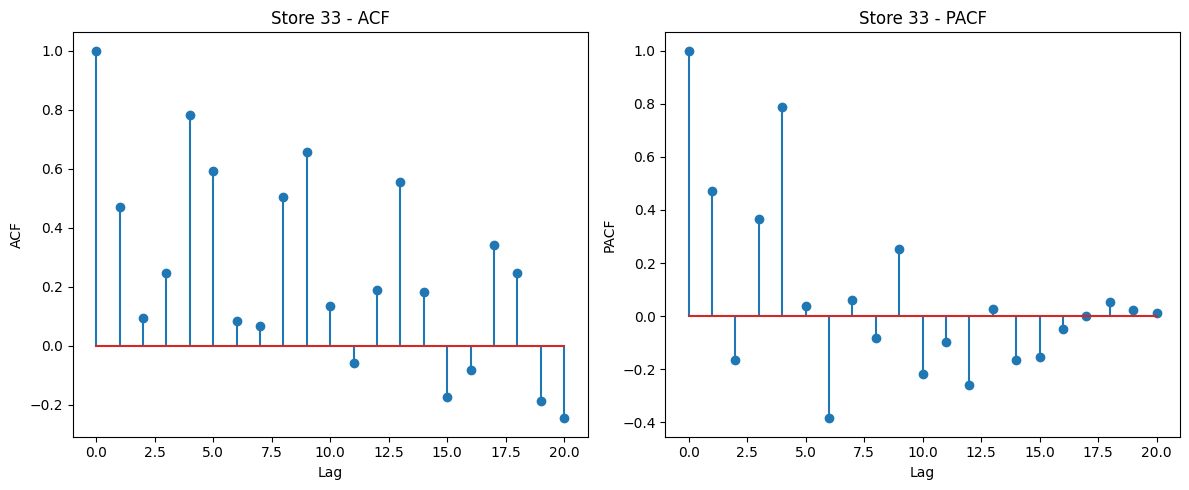

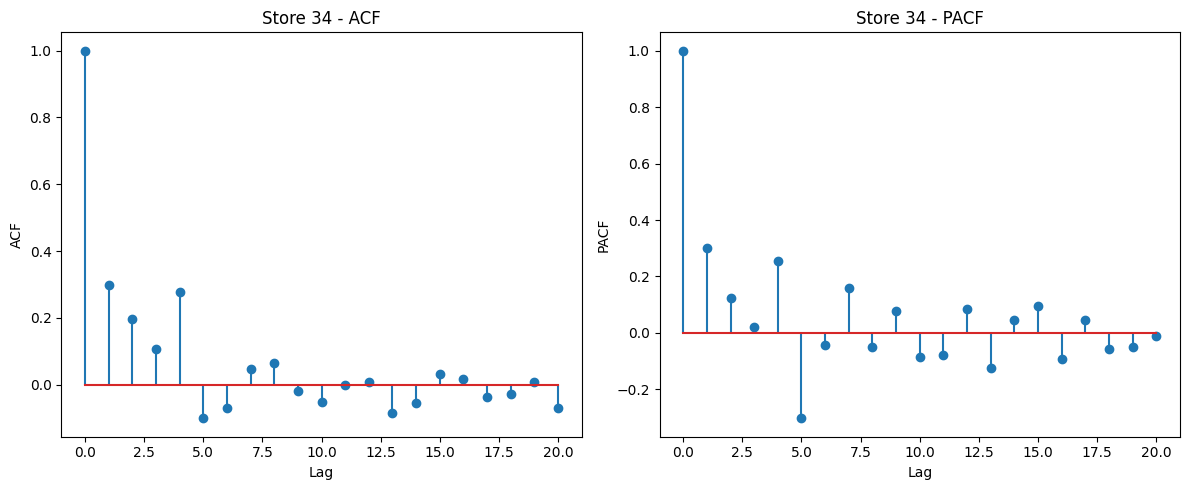

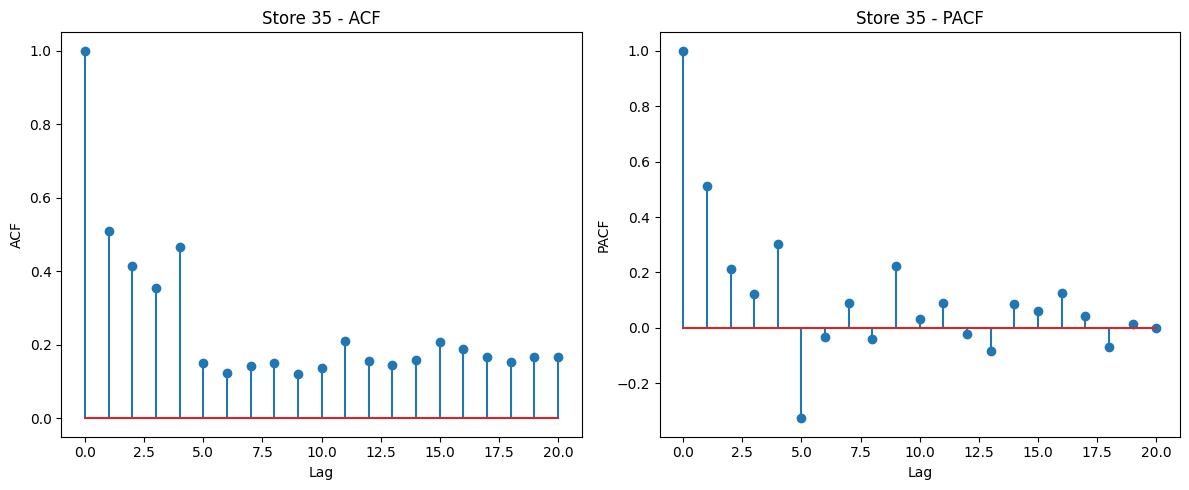

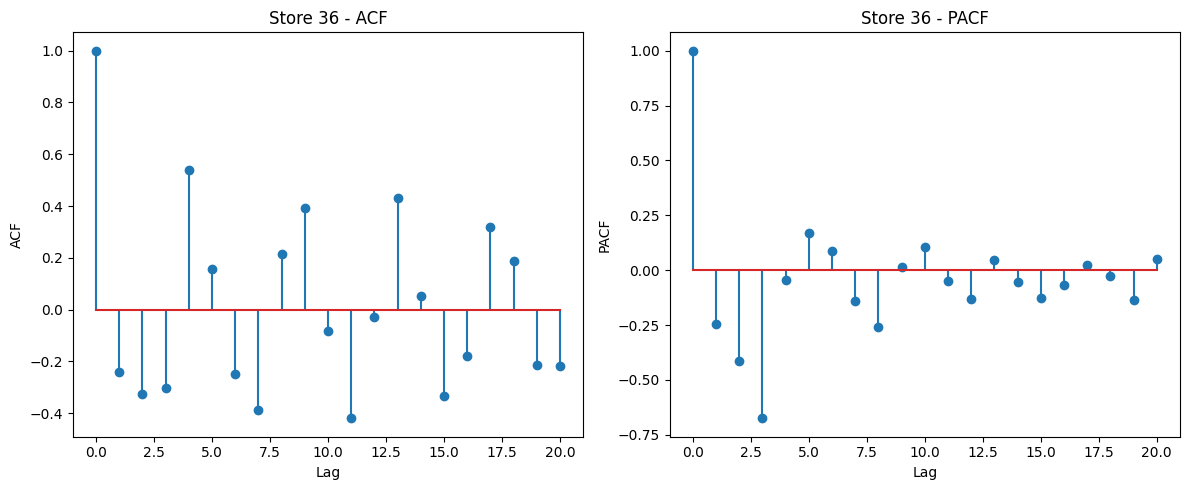

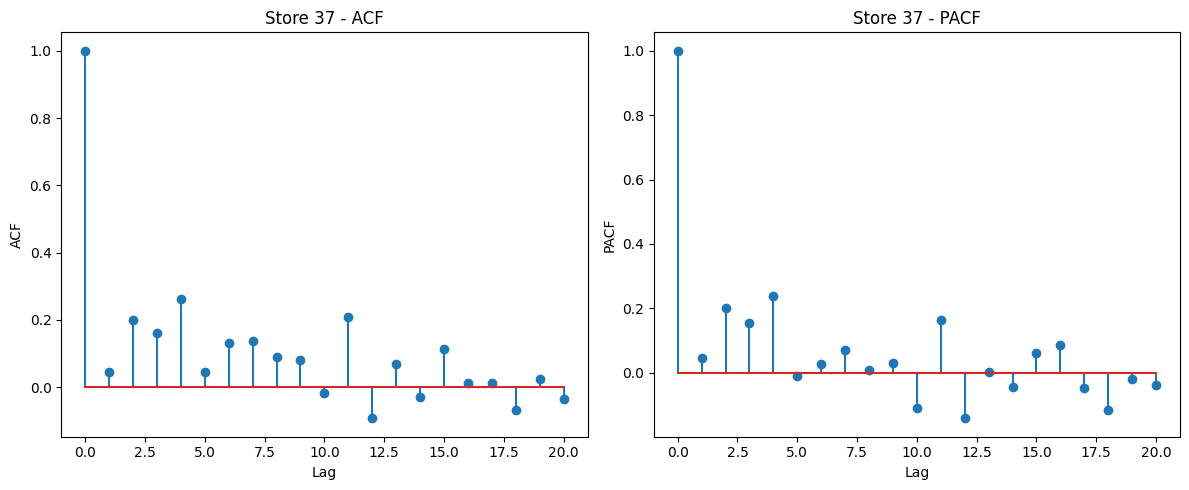

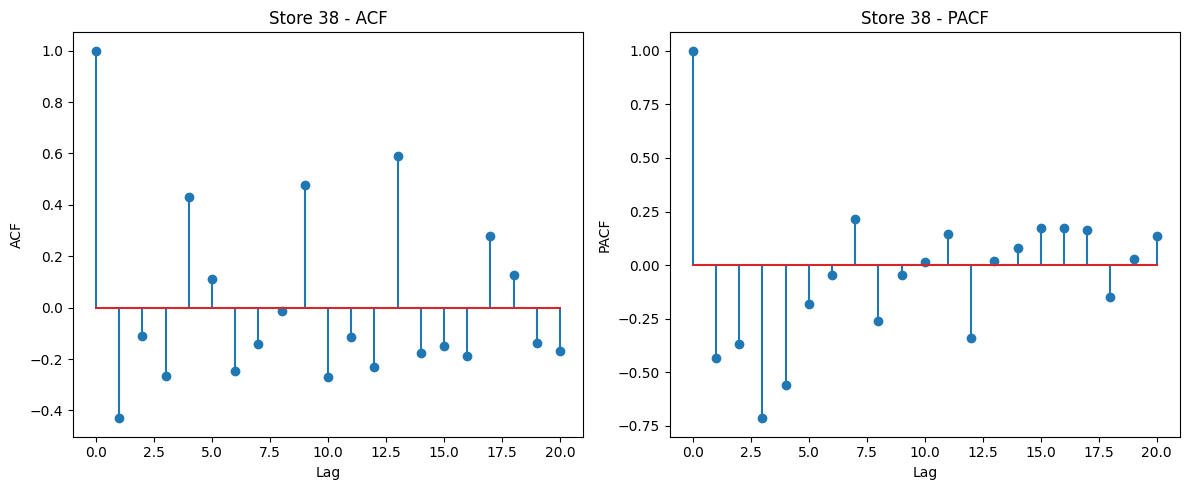

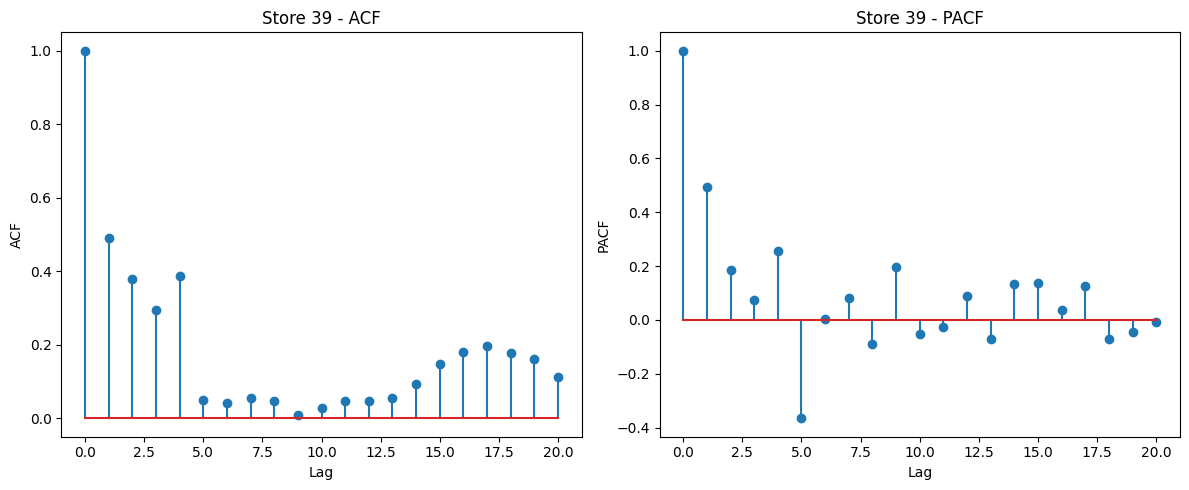

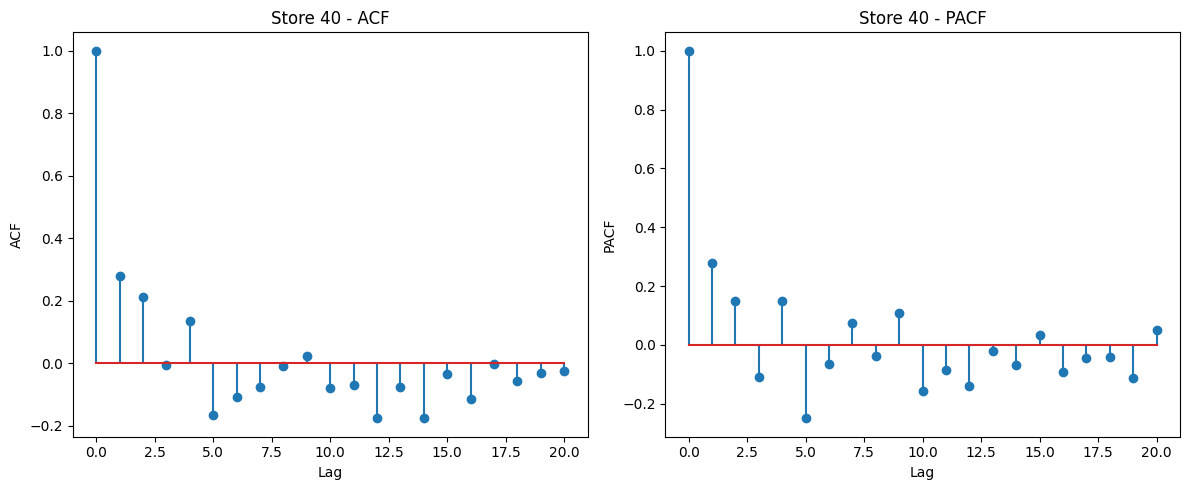

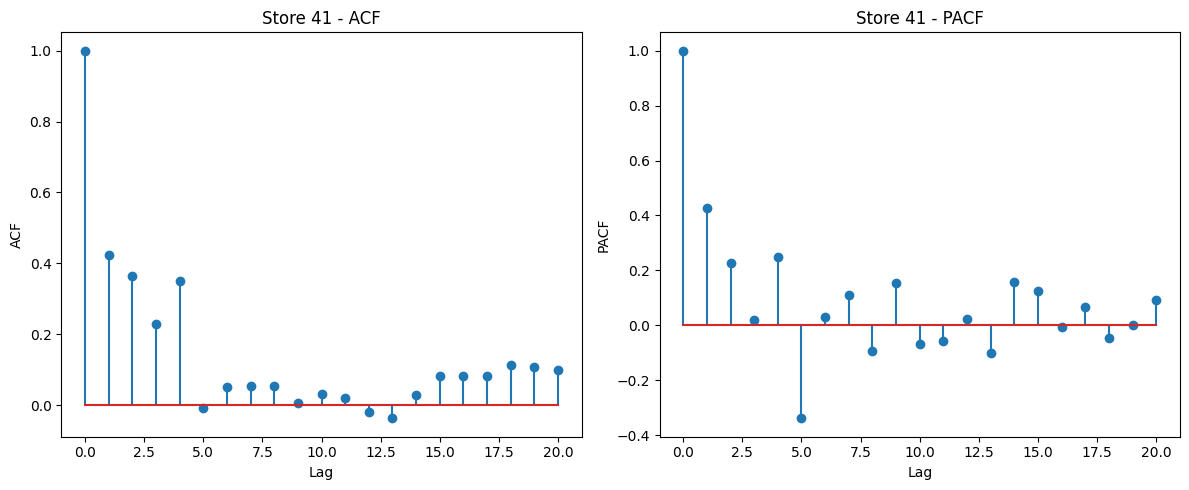

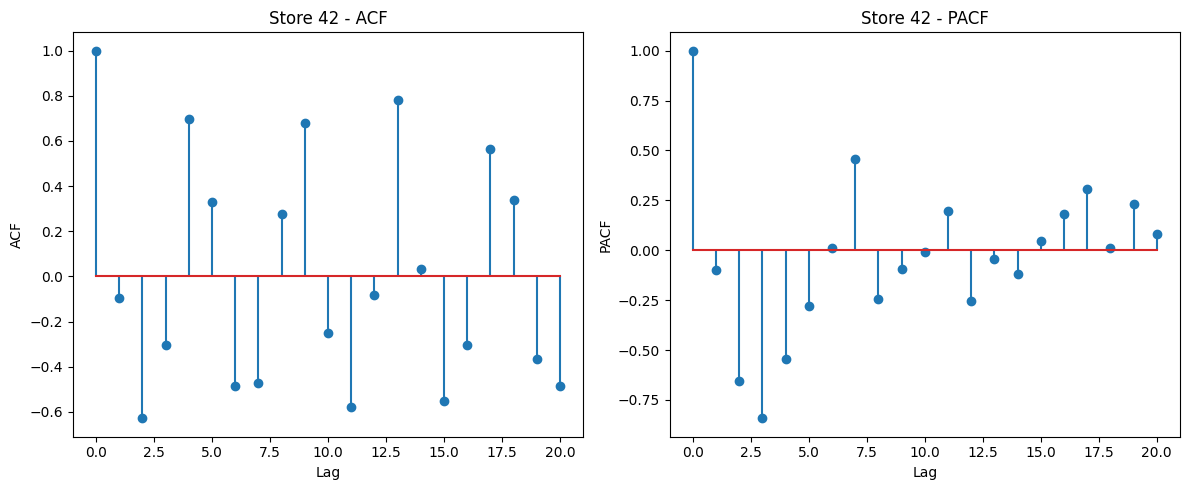

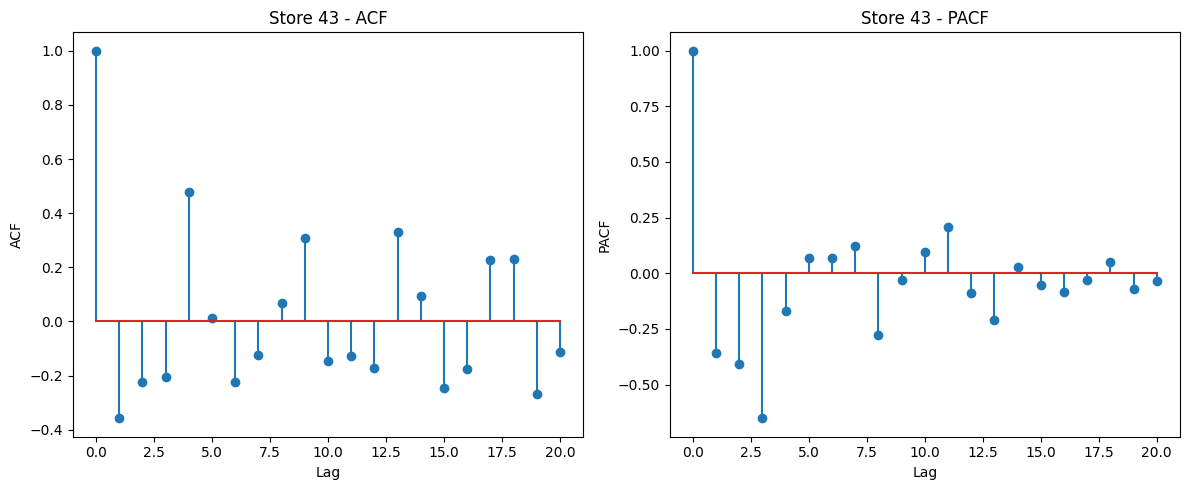

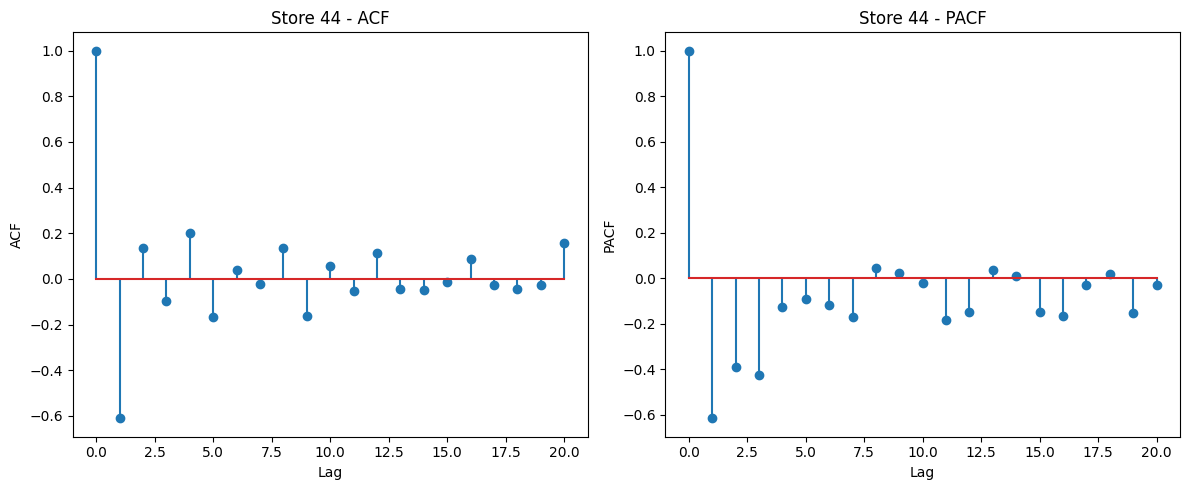

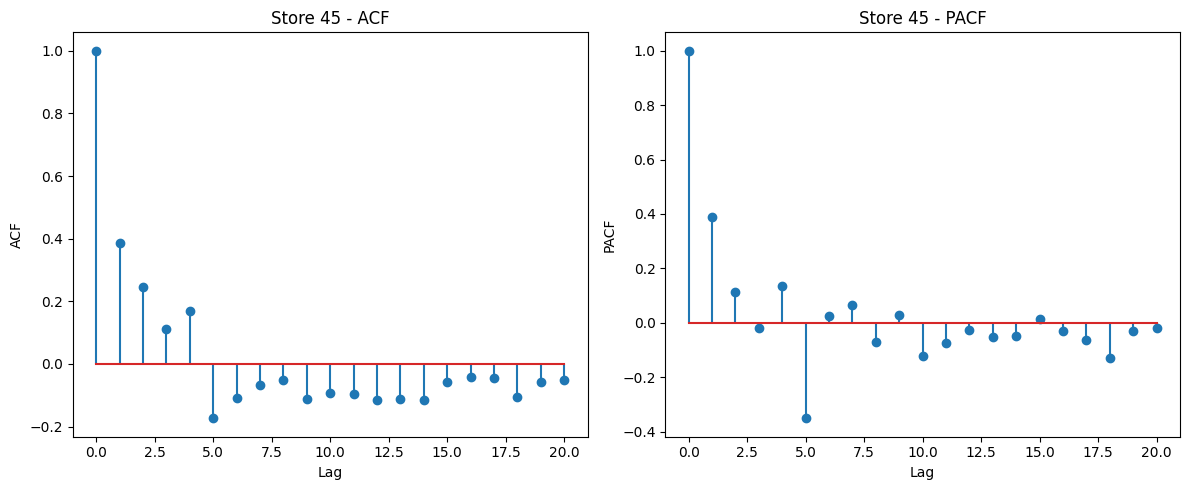

In [18]:
plot_acf_pacf_for_each_store(stationary_df, nlags=20)

# <a> Forecating and evalution of the model

# SARIMA Model

The **SARIMA (Seasonal AutoRegressive Integrated Moving Average)** model is an extension of the ARIMA model that supports **seasonal data**. It is widely used for forecasting time series data that exhibits **trend and seasonality**.

---

## 1. Model Overview

SARIMA incorporates both **non-seasonal** and **seasonal components**:

- **Non-seasonal (ARIMA) part**:  
  - `p` → order of **autoregression (AR)**  
  - `d` → degree of **differencing**  
  - `q` → order of **moving average (MA)**  

- **Seasonal part**:  
  - `P` → seasonal autoregressive order  
  - `D` → seasonal differencing order  
  - `Q` → seasonal moving average order  
  - `s` → length of the seasonal cycle (e.g., 12 for monthly data with yearly seasonality)

The full SARIMA model is denoted as:

$$
SARIMA(p,d,q)(P,D,Q,S)
$$



## 2. Key Features

1. **Handles Trend**: Differencing removes trend (`d` and `D` terms).  
2. **Handles Seasonality**: Seasonal AR and MA terms capture repeated patterns.  
3. **Flexible**: Can model a wide range of seasonal time series data.  



## 3. Model Equation

SARIMA combines non-seasonal and seasonal components:
$$
\Phi_P(L^s) \phi_p(L) (1-L)^d (1-L^s)^D y_t = \Theta_Q(L^s) \theta_q(L) \epsilon_t
$$

Where:  
- L is the lag operator  
- φ_p(L) and θ_q(L) are non-seasonal AR and MA polynomials  
- φ_P(L^s) and θ_Q(L^s) are seasonal AR and MA polynomials  
- εt is white noise  


In [ ]:
def sarima_forecast_store(df, store, order=(1,1,1), seasonal_order=(1,1,1,52), steps=4):
    store_df = df[df["Store"] == store].sort_values("Date")
    y = store_df["Weekly_Sales"]

    # Fit SARIMA model
    model = SARIMAX(y, order=order, seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit(disp=False)

    # Forecast
    forecast = results.get_forecast(steps=steps)
    forecast_index = pd.date_range(start=store_df["Date"].max(), periods=steps+1, freq="W")[1:]
    forecast_series = pd.Series(forecast.predicted_mean.values, index=forecast_index)

    # Combine past and future
    combined_df = pd.concat([
        pd.Series(y.values, index=store_df["Date"]),
        forecast_series
    ])

    return combined_df, forecast_series

## 1. Mean Squared Error (MSE)

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

Where:  
- yᵢ = actual value  
- ŷᵢ = predicted value  
- n  = number of observations



## 2. Root Mean Squared Error (RMSE)

$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2} = \sqrt{\text{MSE}}
$$ 

RMSE is in the same unit as the target variable, making it easier to interpret.



## 3. Mean Absolute Error (MAE)

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$

MAE measures the average magnitude of errors without considering their direction.



## 4. Mean Absolute Percentage Error (MAPE)

$$
\text{MAPE} = \frac{100\%}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right|
$$ 

MAPE expresses the error as a percentage of the actual values, which is useful for relative error comparison.

In [20]:
# Root Mean Squared Error function
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Function to fit SARIMA and evaluate
def evaluate_sarima_store(df, store, order=(1,1,1), seasonal_order=(1,1,1,52), steps=4):
    store_df = df[df["Store"] == store].sort_values("Date")
    y = store_df["Weekly_Sales"]

    # Train-Test Split (last 'steps' weeks for test)
    train = y.iloc[:-steps]
    test = y.iloc[-steps:]

    # Fit SARIMA on training data
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit(disp=False)

    # Forecast
    forecast = results.get_forecast(steps=steps).predicted_mean

    # Compute metrics
    mse = mean_squared_error(test, forecast)
    mae = mean_absolute_error(test, forecast)
    rmse = root_mean_squared_error(test, forecast)
    mape = mean_absolute_percentage_error(test, forecast) * 100  # in %

    return mse, mae, rmse, mape, test, forecast

# Evaluate for all stores
mse_mae_results = []
for store in sorted(df["Store"].unique()):
    try:
        mse, mae, rmse, mape, actual, predicted = evaluate_sarima_store(df, store, order=(1,1,1))
        mse_mae_results.append({
            "Store": store,
            "MSE": mse,
            "MAE": mae,
            "RMSE": rmse,
            "MAPE (%)": mape
        })
    except Exception as e:
        print(f"Error with store {store}: {e}")

In [21]:
# Convert results into DataFrame for nice view
results_df = pd.DataFrame(mse_mae_results)
results_df

,Store,MSE,MAE,RMSE,MAPE (%)
0,1,1.643626e+09,33670.286486,40541.655279,2.175647
1,2,3.720055e+09,57448.652446,60992.255941,3.009173
2,3,1.020013e+08,8619.705901,10099.568980,2.076865
3,4,8.887813e+09,69395.110197,94275.196621,3.272010
4,5,1.955743e+08,12297.917890,13984.786758,3.746659
5,6,1.385092e+09,33168.538614,37216.819769,2.284418
6,7,1.106771e+09,31309.903257,33268.167899,6.190595
7,8,8.069186e+08,25703.857474,28406.312353,2.820292
8,9,1.253161e+09,30737.691074,35400.013962,5.499502
9,10,1.094842e+09,28889.228959,33088.396044,1.653692


# <a> Future Forecasting </a>

In [23]:
def prepare_forecasts(df, steps=4):
    store_forecasts = {}
    for store in sorted(df["Store"].unique()):
        try:
            combined_df, forecast_series = sarima_forecast_store(df, store, steps=steps)
            store_forecasts[store] = (combined_df, forecast_series)
        except Exception as e:
            print(f"Error with store {store}: {e}")
    return store_forecasts

In [24]:
store_forecasts = prepare_forecasts(df, steps=4)

In [26]:
# Create dropdown Plotly chart
fig = go.Figure()

# Initial store
initial_store = list(store_forecasts.keys())[0]
combined_df, forecast_series = store_forecasts[initial_store]

fig.add_trace(go.Scatter(
    x=combined_df.index,
    y=combined_df.values,
    mode="lines+markers",
    name=f"Store {initial_store} Sales",
    line=dict(color="blue")
))

# Highlight forecast in red
fig.add_trace(go.Scatter(
    x=forecast_series.index,
    y=forecast_series.values,
    mode="lines+markers",
    name="Forecast",
    line=dict(color="red", dash="dash")
))

# Dropdown buttons
dropdown_buttons = []
for store in store_forecasts.keys():
    combined_df, forecast_series = store_forecasts[store]

    dropdown_buttons.append(dict(
        method="update",
        label=f"Store {store}",
        args=[
            {
                "x": [combined_df.index, forecast_series.index],
                "y": [combined_df.values, forecast_series.values]
            },
            {
                "title": f"Weekly Sales + Next 4 Weeks Forecast for Store {store}"
            }
        ]
    ))

fig.update_xaxes(
    rangeslider_visible = True,
    showgrid = True,
    gridcolor = "lightgray"
)

fig.update_yaxes(
    showgrid = True,
    gridcolor = "lightgray"
)

# Layout
fig.update_layout(
    title=f"Weekly Sales + Next 4 Weeks Forecast for Store {initial_store}",
    xaxis_title="Date",
    yaxis_title="Weekly Sales",
    updatemenus=[dict(
        buttons=dropdown_buttons,
        direction="down",
        showactive=True,
        x=1.15,
        y=1.15
    )],
    height=700,
    plot_bgcolor="lightgray",
    paper_bgcolor="white"
)

fig.show()